In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import sympy as sp

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=2) # this will round everything

# LDA (Linear Discriminant Analysis)

In simple words, LDA's goal is to separate data by type using linear models in the best possible way. The basic strategy is to find a line such that the distance between projected means of distinct types/classes is maximal while the variance within each class is minimal. At the same time, LDA also allows us to reduce dimension of our data in a meaningful way. It is a bit similar to PCA. The main difference from PCA is that ${\bf \text{LDA}}$ is a supervised algorithm, which means it has to be used on labeled data, because it ${\bf \text{tries to separate different types of data}}$, while ${\bf \text{PCA is mostly interested in maximazing variance of the whole data}}$. It might seems like LDA is a better algorithm, but it is not always the case. In fact, sometimes for small amount of classes PCA can outperform LDA. In reality however, it is quite common to use both algorithms sequentially.

I will do 2 examples in this set:
1. Simple set to explain LDA
2. Real life set with LDA

As mentioned before, given a group data, LDA will try to find a way to separate different types of data as much as possible. Consider the following image below. Our data is divided into two classes (red and blue). We want to find the line the separates these classes in the best way. We want large separation between classes. We can do that by trying to maximize distance between means of each class (between-class variance). However, this is not enough. We also want to minimize the spread of data in each class (small within-class variance), since we dont want to have overlap between classes. 

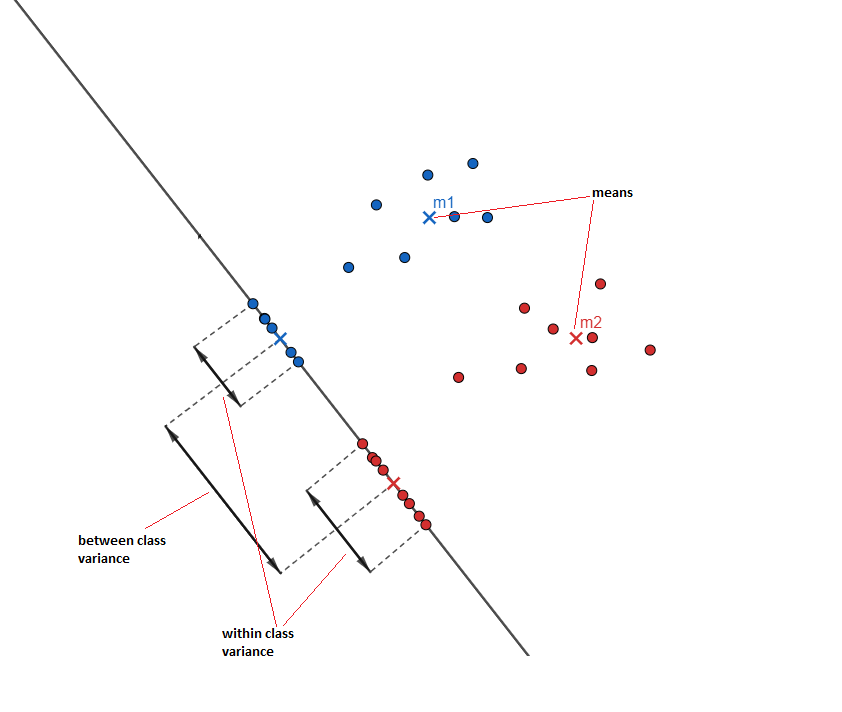


To stress why the second condition is important consider example below. The line L1 maximizes distance between means, but it is not a good choice. In fact L2 is a much better choice. Its within-class variance is minimal.

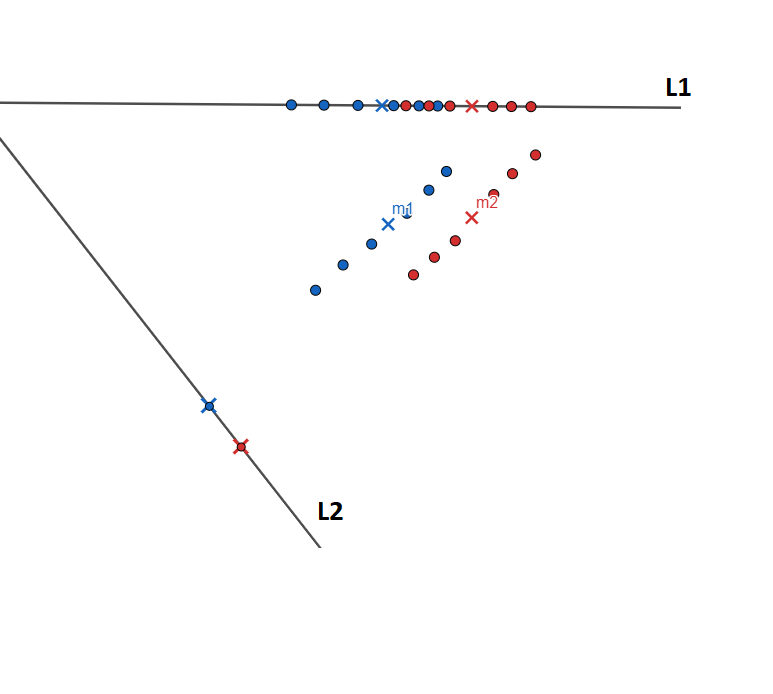

#### LDA with 2 classes example

Suppose we have 2-dim data points separated into two classes:

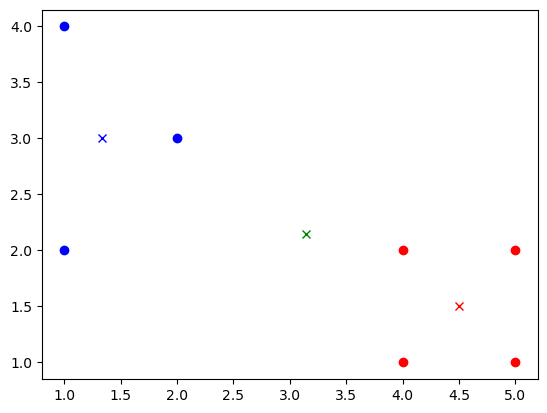

In [13]:
#Given data
RED=np.array([[5,2],[5,1], [4,1],[4,2] ])
BLUE=np.array([[1,4],[2,3],[1,2]])
Total=np.concatenate((RED, BLUE))

#Means of each class and overall mean
mr=np.mean(RED,axis=0)
mb=np.mean(BLUE,axis=0)
m=np.mean(Total,axis=0)

#Let's plot data and means
xr,yr=RED.T
plt.scatter(xr,yr,color='r')
xb,yb=BLUE.T
plt.scatter(xb,yb,color='b')

plt.plot(mr[0],mr[1], marker='x',color='r')
plt.plot(mb[0],mb[1], marker='x',color='b')
plt.plot(m[0],m[1], marker='x',color='g')
plt.show()

Note that we care only about slope of the line on which we will project our data points. Therefore, we can assume that out line goes through origin in the direction of some unit vector ${\bf v}$. Recall to project a vector ${\bf x}$ onto a line going through origin in the direction of a unit vector ${\bf v}$, we can calculate ${\bf v} \cdot {\bf x} ={\bf x}^T {\bf v} = {\bf v}^T {\bf x}$.

First, lets try to measure distance between projected means of different classes (Note: we are talking here about projected means, not the actual means). Let $C_1$ and $C_2$ represent classes we have and let $n_1$ and $n_2$ be their sizes; let $x_i$ be a data point and $p_i$ be corresponding projected data point. Let $\bf{\mu_1}$ and $\bf{\mu_2}$ be means of projected data and ${\bf m}_1$ and ${\bf m}_2$ be original means. Then we can see that means of projected data is just a projection of original means; for $j=1, 2$:
$${\bf \mu_j}=\frac{1}{n_j}\sum_{{\bf x}_i\in C_j}p_i=\frac{1}{n_j}\sum_{{\bf x}_i\in C_j}{\bf v}^T{\bf x}_i={\bf v}^T\frac{1}{n_j}\sum_{{\bf x}_i\in C_j}{\bf x}_i={\bf v}^T {\bf m}_j$$

We want to maximize distance between means over all unit vectors ${\bf v} $:
$$\max_{{\bf v}:||{\bf v}||=1} ||\mu_1-\mu_2||,$$
which is equivalent to maximizing:
$$\max_{{\bf v}:||{\bf v}||=1}||\mu_1-\mu_2||^2$$

Secondly, we want to minimize projected variances $s_1^2$ and $s_2^2$. Each can be calculated by $$s_j^2=\frac{1}{n_j-1}\sum_{{\bf x}_i\in C_j}||p_i-\mu_j||^2$$
Finally, we can combine both condition into one:
$$\max_{{\bf v}:||{\bf v}||=1}\frac{||\mu_1-\mu_2||^2}{s_1^2+s_2^2}$$
Notice, to maximize the whole expression, we want large numerator and small denominator.

This is what we want, but how do we actually do it?


Let's look at numerator first:
$$||\mu_1-\mu_2||^2=||({\bf m}_1-{\bf m}_2)^T {\bf v} ||^2={\bf v}^T({\bf m}_1-{\bf m}_2) \cdot ({\bf m}_1-{\bf m}_2)^T{\bf v}={\bf v}^T S_b {\bf v}$$
Here $S_b$ is a square, symmetric, positive defininite matrix called **between-class scatter matrix**.

In [14]:
Sb=np.outer(mr-mb,mr-mb);Sb

array([[10.03, -4.75],
       [-4.75,  2.25]])

In [15]:
np.linalg.matrix_rank(Sb)

1

Note that the rank of this matrix is 1 (i.e. It will have only one meaningful dimension). In general, the rank of $S_b$ is one less than the number of classes. So, since we have only two classes in this problem, the rank is 1. This will be important later.

Next, we will consider denominator. For each class separatelly, we can perform similar computation as above to show:
$$s_j^2=\frac{1}{n_i-1}{\bf v}^T \left(\sum_{{\bf x}_i \in C_j}({\bf x}_i-{\bf m}_j)({\bf x}_i-{\bf m}_j)^T \right) {\bf v}={\bf v}^T S_j {\bf v},$$
where $S_j$ is called **within-class scatter matrix** for class j. 

Finally we can compute **total within-class scatter matrix** $S_w=S_1+S_2$, since
$$ s_1^2+s_2^2={\bf v}^T S_1 {\bf v}+{\bf v}^T S_2 {\bf v}={\bf v}^T (S_1+S_2) {\bf v} = {\bf v}^T S_w {\bf v}.$$
Note that $S_w$ is also square, symmetric and positive definite.

In [31]:
S1=np.zeros((2,2))
for i in range(len(RED)):
    S1=S1+np.outer(RED[i]-mr, RED[i]-mr)
S1=S1/(len(RED)-1)
S2=np.zeros((2,2))
for i in range(len(BLUE)):
    S2=S2+np.outer(BLUE[i]-mb, BLUE[i]-mb)
S2=S2/(len(BLUE)-1)
Sw=S1+S2
Sw

array([[0.67, 0.  ],
       [0.  , 1.33]])

Now, putting it all together:
$$\max_{{\bf v}:||{\bf v}||=1}\frac{||\mu_1-\mu_2||^2}{s_1^2+s_2^2}=\max_{{\bf v}:||{\bf v}||=1}\frac{{\bf v}^T S_b {\bf v}}{{\bf v}^T S_w {\bf v}}$$

We already know how to maximize numerator or minimize denominator separatelly. It all have to do with eigenvalues of corresponding symmetric matrices. Our problem is actually quite similar

**Theorem** *If $S_w$ is invertible, then the maximum to above problem is given by the largest eigenvector of $S_w^{-1}S_b$*

In [32]:
Max=np.linalg.inv(Sw)@Sb;
Max

array([[15.04, -7.12],
       [-3.56,  1.69]])

In [33]:
np.linalg.eig(Max)

(array([1.67e+01, 4.89e-16]),
 array([[ 0.97,  0.43],
        [-0.23,  0.9 ]]))

In [34]:
# we can see that first eigenvector is the largest one:
ev=np.linalg.eig(Max)[1][:,0];ev

array([ 0.97, -0.23])

Let's plot what we have:

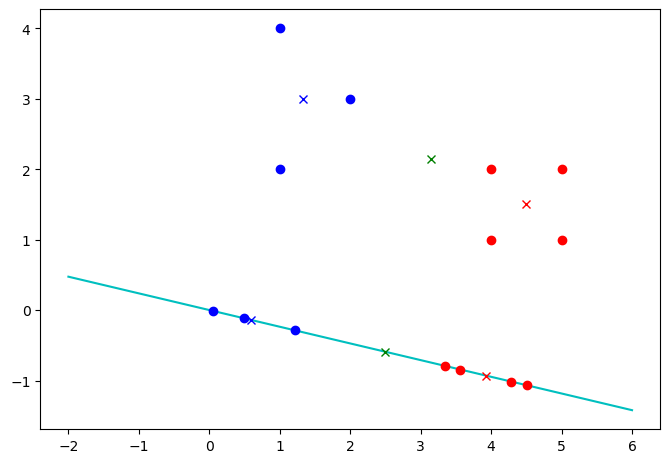

In [35]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_aspect(1)

#calculating projections:

Bp=(BLUE@ev)
Rp=(RED@ev)
mrp=(mr@ev)*ev
mbp=(mb@ev)*ev
mp=(m@ev)*ev

#setting up the line

lx=np.linspace(-2,6,100)
ly=lx*ev[1]/ev[0]
plt.plot(lx,ly,'-c')  

# original data

plt.scatter(xr,yr,color='r')
plt.scatter(xb,yb,color='b')

plt.plot(mr[0],mr[1], marker='x',color='r')
plt.plot(mb[0],mb[1], marker='x',color='b')
plt.plot(m[0],m[1], marker='x',color='g')

# plotting projections

for i in range(len(Rp)):
    plt.plot(Rp[i]*ev[0],Rp[i]*ev[1], marker='o',color='r')
for i in range(len(Bp)):
    plt.plot(Bp[i]*ev[0],Bp[i]*ev[1], marker='o',color='b')

plt.plot(mrp[0],mrp[1], marker='x',color='r')
plt.plot(mbp[0],mbp[1], marker='x',color='b')
plt.plot(mp[0],mp[1], marker='x',color='g')
plt.show()

In the above example we did few things:
1. We reduced dimension from 2 to 1 without losing too much information. The dimension reduction is actually bounded and is based on rank of $S_w^{-1}S_b$, which is the same as rank of $S_b$. So, if we have only 2 classes, LDA will project onto 1-dim line.
2. We can use projected global mean (green) as a division point. In other words, if the data represented something real and we got another point with unknown color, we can make a good guess what its color is by checking where it lands with respect to the mean.

In the next example, we will use higher dimensional real life data with 3 classes. With 3 classes, we can project onto at most 2 dimensions. So, in this example, we will reduce it to 2 dimension using similar commands and then redo it using special commands from `sklearn` library

### Penguin LDA

We will use cleaned penguin file from tutorial 3.


In [36]:
df=pd.read_csv('penguins_size_clean.csv')
df['sex']=df.sex.map({'MALE':0,'FEMALE':1})
df['species']=df.species.map({'Adelie':0,'Chinstrap':1, 'Gentoo':2})
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,Torgersen,39.1,18.7,181,3750,0
1,0,Torgersen,39.5,17.4,186,3800,1
2,0,Torgersen,40.3,18.0,195,3250,1
3,0,Torgersen,36.7,19.3,193,3450,1
4,0,Torgersen,39.3,20.6,190,3650,0
...,...,...,...,...,...,...,...
328,2,Biscoe,47.2,13.7,214,4925,1
329,2,Biscoe,46.8,14.3,215,4850,1
330,2,Biscoe,50.4,15.7,222,5750,0
331,2,Biscoe,45.2,14.8,212,5200,1


We will use last 5 columns to predict species type. To do that we will split this table into 2 tables: X will contain last 5 columns and y to contain species column. Think of this as a transformation y=T(X). Given 5 measures, we want to see what is the species.

In [37]:
X=np.array(df.iloc[:,2:7])
y=np.array(df.iloc[:,0])

First we compute the means for each class. 

In [38]:
mean_vectors = []
for cl in range(3):
    mean_vectors.append(np.mean(X[y==cl], axis=0))   #note how we selected rows in X based on class in y.
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl]))

Mean Vector class 0: [3.88e+01 1.83e+01 1.90e+02 3.71e+03 5.00e-01]

Mean Vector class 1: [4.88e+01 1.84e+01 1.96e+02 3.73e+03 5.00e-01]

Mean Vector class 2: [4.76e+01 1.50e+01 2.17e+02 5.09e+03 4.87e-01]



For within-class scatter matrix $S_w$, nothing really changes. We just have 3 classes now. [Note: `applyfunc` part just rounds all entries of the matrix in the output. I am not changing the actual matrix]

In [91]:
Sw = np.zeros((5,5))

for cl,mv in enumerate(mean_vectors):
    class_sc_mat = np.zeros((5,5))                          # scatter matrix for every class
    n=0
    for row in X[y == cl]:
        class_sc_mat = class_sc_mat + np.outer(row-mv,row-mv)
        n+=1
    Sw = Sw + class_sc_mat/(n-1)                              # sum class scatter matrices
    

print('Within-class Scatter Matrix:')
sp.Matrix(Sw).applyfunc(lambda x: '{:.1f}'.format(x))

Within-class Scatter Matrix:


Matrix([
[  27.9,   5.7,   30.6,   2362.4,   -2.9],
[   5.7,   3.7,   11.8,    945.7,   -1.2],
[  30.6,  11.8,  136.8,   5498.0,   -5.5],
[2362.4, 945.7, 5498.0, 609524.2, -477.2],
[  -2.9,  -1.2,   -5.5,   -477.2,    0.8]])

The between-class scatter matrix is a bit different when we have more than two classes. Since we now have more then two means, we can't just find the distance between them to get large separation. Instead, we will see how far each of the means are from the global mean ${\bf M}$. If we have $c$ classes, then
$$ S_b=\sum_{j=1}^{c}N_j ({\bf m}_j-{\bf M}) \cdot ({\bf m}_j-{\bf M})^T,$$
where $N_j$ and ${\bf m}_j$ are the size and the mean of class $j$.

Note that if $c=2$, we will get a scalar multiple of the original formula, which will work just as well as the original definition.

In [92]:
overall_mean = np.mean(X, axis=0)

Sb = np.zeros((5,5))
for cl, mean_vec in enumerate(mean_vectors):  
    n = X[y==cl,:].shape[0]                    # size of each class
    Sb = Sb + n * np.outer(mean_vec - overall_mean,mean_vec - overall_mean)
print('Between-class Scatter Matrix:')
sp.Matrix(Sb).applyfunc(lambda x: '{:.1f}'.format(x))

Between-class Scatter Matrix:


Matrix([
[  7015.4,   -1401.4,   13427.0,    598663.4,    -5.4],
[ -1401.4,     870.8,   -6512.2,   -355385.5,     3.3],
[ 13427.0,   -6512.2,   50525.9,   2674311.3,   -24.4],
[598663.4, -355385.5, 2674311.3, 145190219.1, -1328.1],
[    -5.4,       3.3,     -24.4,     -1328.1,       0]])

In [93]:
np.linalg.matrix_rank(Sb)

2

Now we find eigenvalues and eigenvectors for $S_w^{-1}S_b$. Since the rank is 2, we know we will have only at most 2 non-zero eigenvalues. I will print all of them though to confirm it


In [94]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(5,1)           #converting to column for a nicer display.
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.6f}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.11]
 [ 0.89]
 [-0.08]
 [-0.  ]
 [-0.44]]
Eigenvalue 1: 1785.972738

Eigenvector 2: 
[[ 0.4 ]
 [ 0.17]
 [-0.01]
 [-0.  ]
 [ 0.9 ]]
Eigenvalue 2: 264.554958

Eigenvector 3: 
[[-5.43e-03]
 [-1.69e-01]
 [ 1.47e-02]
 [-6.53e-04]
 [ 9.86e-01]]
Eigenvalue 3: -0.000000

Eigenvector 4: 
[[-1.32e-02]
 [ 7.07e-02]
 [ 2.30e-02]
 [-1.88e-04]
 [ 9.97e-01]]
Eigenvalue 4: -0.000000

Eigenvector 5: 
[[-1.32e-02]
 [ 7.07e-02]
 [ 2.30e-02]
 [-1.88e-04]
 [ 9.97e-01]]
Eigenvalue 5: -0.000000


In [95]:
np.dot(eig_vecs[:,0],eig_vecs[:,1])

(-0.2880548528521439+0j)

We can see that last three eigenvalues are 0, so we can use only the first two eigenvectors. This allows us to reduce our data from 5-dim to 2-dim keeping as much as informaion as we can. We are in essence creating a vector subspace spanned by these two eigenvectors, which also creates new coordinates there (we will call them LD1 and LD2). In fact, from these eigenvectors we can also see how much contribution each parameter gives. For example, from the first eigenvector we get LD1:

$$LD1= -0.11x_1-0.89x_2-0.08x_3+0x_4-0.44x_5,$$
where $x_1$ is culmen_length_mm, $x_2$ is  culmen_depth_mm, etc. Similarly, we can get LD2.

Next, we compute the projection of X onto each eigenvector $X\cdot W$, where columns of $W$ are the first two eigenvectors (Note that these eigenvectors are not orthogonal, but do have norm 1). The result will contain coordinates of all of our data in each subspace.

In [96]:
W = np.vstack((eig_vecs[:,0], eig_vecs[:,1])).T
X_lda = X@W


And now lets plot this. Note that we are going to treat LD1 and LD2 direction as orthogonal for visualization. 

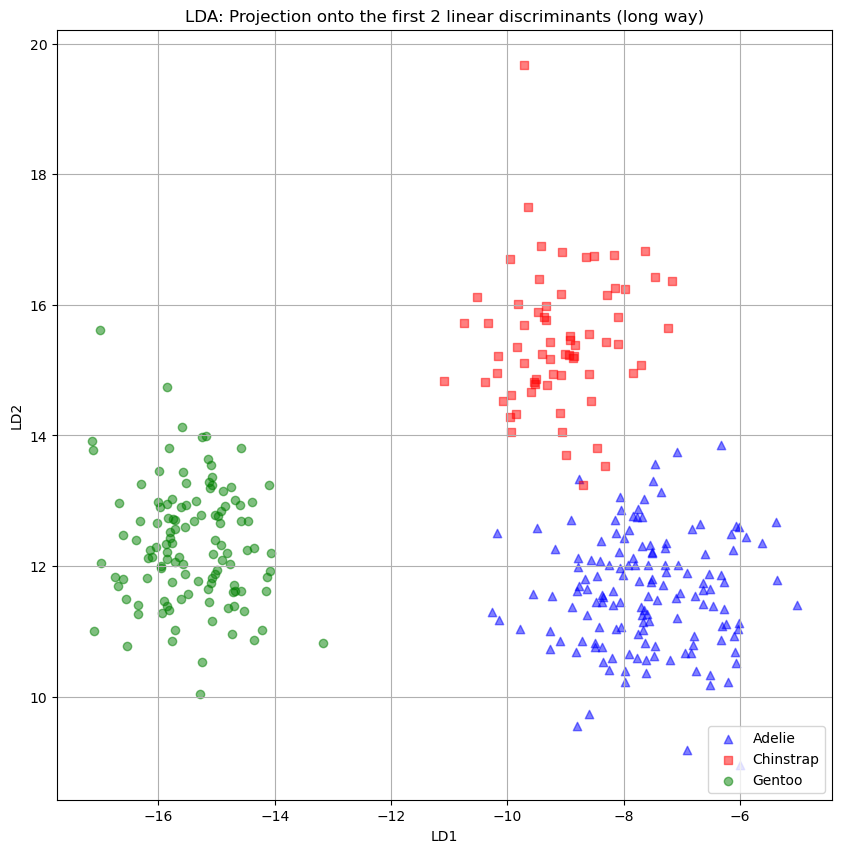

In [97]:

label_dict = {0:'Adelie',1:'Chinstrap', 2:'Gentoo'}
fig, ax = plt.subplots(figsize=(10, 10))

for label,marker,color in zip(
    range(3),('^', 's', 'o'),('blue', 'red', 'green')):

    plt.scatter(x=X_lda[:,0].real[y == label],
            y=X_lda[:,1].real[y == label],
            marker=marker,
            color=color,
            alpha=0.5,
            label=label_dict[label]
            )

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='lower right', fancybox=True)
plt.title('LDA: Projection onto the first 2 linear discriminants (long way)')


plt.grid()
plt.show()


Compare this to the scatter plots from seaborn library in Tutorial 3, where we would just compare two of the 5 parameters. It isn't hard to see that this gave us a much better separation. 

Finally, here is a shorcut of doing exactly the same but using sklearn library. After we import file and get X and y, we can use the following two lines.

Note: `n_components` has to be less than number of classes. It is the final dimension of of our reduced data. This does mean that if you have only 2 classes, you can only reduced to a 1-dim space. This is why LDA is better used when we have more than two classes.

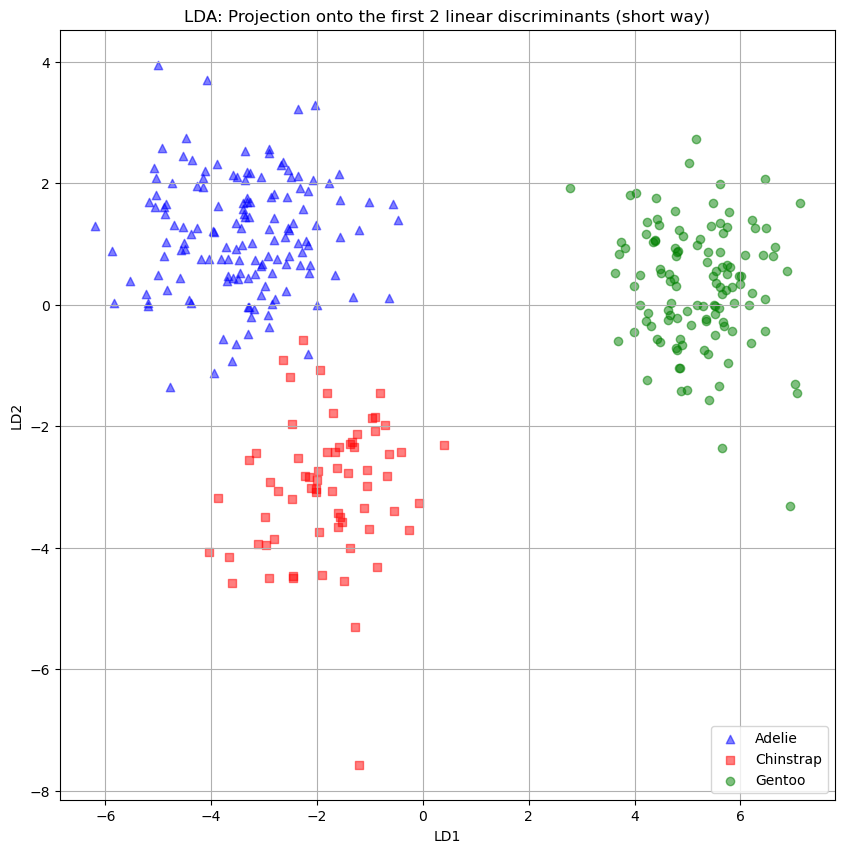

In [98]:
sklearn_lda = LDA(n_components=2)          
X_lda_sk = sklearn_lda.fit_transform(X, y)

# that is it. now we just plot again:

fig, ax = plt.subplots(figsize=(10, 10))

for label,marker,color in zip(
    range(3),('^', 's', 'o'),('blue', 'red', 'green')):

    plt.scatter(X_lda_sk[y == label, 0],
                X_lda_sk[y == label, 1],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='lower right', fancybox=True)
plt.title('LDA: Projection onto the first 2 linear discriminants (short way)')


plt.grid()
plt.show()

As a little extra, we are going to separate our data in regions. We will use Logistic Regression to do it (it is a bit similar to linear regression, but instead of matching the trend, we want to do the opposite and separate classes). Such separation is useful if you do machine learning for example. The assumption here is that the data we have is a training data set and we split everything into 3 regions. If we get an unknown penguin, we can test to which region it belongs and deduce its species. 

In real life, this is a bit more complicated as we would have to split data we have into training set and test set, so that we can understand better if our approach works well.

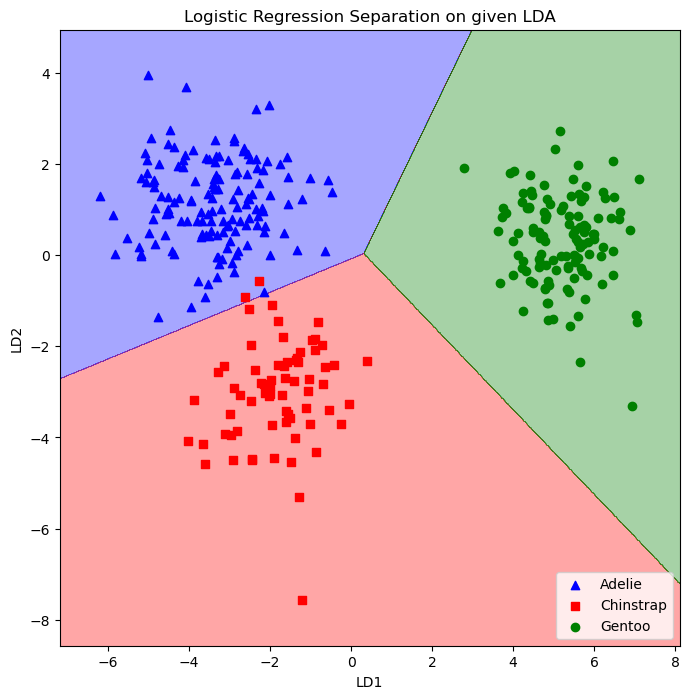

In [55]:
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression


classifier = LogisticRegression(random_state = 0)
classifier.fit(X_lda_sk, y)

plt.figure(figsize=(8, 8))

# create regions
X1, X2 = np.meshgrid(np.arange(start = X_lda_sk[:, 0].min() - 1, stop = X_lda_sk[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_lda_sk[:, 1].min() - 1, stop = X_lda_sk[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.35, cmap = ListedColormap(['blue', 'red', 'green']))

# plot the data
for label,marker,color in zip(
    range(3),('^', 's', 'o'),('blue', 'red', 'green')):
    
    plt.scatter(X_lda_sk[y == label, 0],
                X_lda_sk[y == label, 1],
                c = color,
                marker=marker, 
                label = label_dict[label])
    
plt.title('Logistic Regression Separation on given LDA')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right', fancybox=True)

plt.show()